# Installing the Cheminformatics Package

My empty project: 

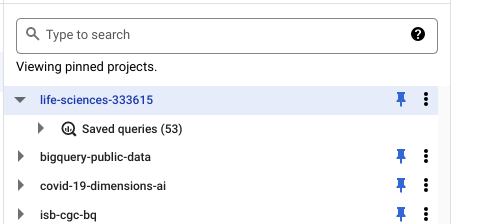

Go install the cheminformatics packge from here [Cheminformatics in BQ](https://github.com/vjb-collab/cheminformatics-bq)

Then you have this

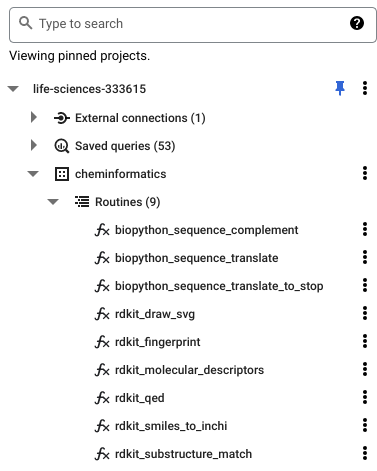

# Creating a Compound Registry

Create some test data set to start with. We use the bin_id to partition the data set

In [100]:
%%timeit -n 1 -r 1
%%bigquery

BEGIN

CREATE SCHEMA sample_data;

create or replace table `sample_data.smiles` as
(
SELECT product_smiles as smiles,
fhoffa.x.random_int(0,3999) as bin_id 
from `nih-nci-cbiit-chem-prod.savi.plus` 
where rand() < 0.01
);

END

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 953.90query/s] 

15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The sample data has 10 million compounds in it

Now partition the table. This isn't always necessary but here it leads to a major speedup in the remote function execution times.

In [101]:
%%timeit -n 1 -r 1
%%bigquery

CREATE TABLE sample_data.smiles_bin_parted (smiles STRING, bin_id INT64)
PARTITION BY
  RANGE_BUCKET(bin_id, GENERATE_ARRAY(0, 3999, 1))
as
(select * from sample_data.smiles)

Query complete after 0.00s: 100%|██████████| 2/2 [00:00<00:00, 1103.47query/s]                        

41.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Create an exports dataset to store intermediate transform data

In [102]:
%%bigquery

CREATE SCHEMA exports;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1106.97query/s]


""


Calculate fingerprints and descriptors

In [103]:
%%timeit -n 2 -r 2

%%bigquery 

create or replace table `exports.smiles_fp_mol_descriptors_json` as
(
SELECT smiles,
`cheminformatics.rdkit_fingerprint`(smiles) as fingerprint_json,
`cheminformatics.rdkit_molecular_descriptors`(smiles) as molecular_descriptors_json,
from `sample_data.smiles_bin_parted` 
)

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1994.75query/s]                        

3min 28s ± 18.2 s per loop (mean ± std. dev. of 2 runs, 2 loops each)


Extract data from json and cluster table.

In [104]:
%%timeit -n 1 -r 1

%%bigquery

create or replace table `exports.smiles_fp_mol_descriptors_clustered`
cluster by num_carbon, num_nitrogen, num_oxygen, num_fluorine
as
(
SELECT smiles,
FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_pattern_long_as_binary_hex'))  as fp_pattern_as_binary,
FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_morgan_as_binary_hex'))  as fp_morgan_as_binary,
CAST(JSON_VALUE(fingerprint_json, "$.num_carbon") as INT64) as num_carbon,
CAST(JSON_VALUE(fingerprint_json, "$.num_oxygen") as INT64) as num_oxygen,
CAST(JSON_VALUE(fingerprint_json, "$.num_nitrogen") as INT64) as num_nitrogen,
CAST(JSON_VALUE(fingerprint_json, "$.num_fluorine") as INT64) as num_fluorine,
CAST(JSON_VALUE(fingerprint_json, "$.num_sulfur") as INT64) as num_sulfur,
CAST(JSON_VALUE(molecular_descriptors_json, "$.ExactMolWt") as FLOAT64 ) as exact_mol_wt,
CAST(JSON_VALUE(molecular_descriptors_json, "$.FractionCSP3") as FLOAT64 ) as fraction_csp3,
CAST(JSON_VALUE(molecular_descriptors_json, "$.BalabanJ") as FLOAT64 ) as balabanj,
CAST(JSON_VALUE(molecular_descriptors_json, "$.BertzCT") as FLOAT64 ) as bertzct,
CAST(JSON_VALUE(molecular_descriptors_json, "$.HallKierAlpha") as FLOAT64 ) as hallkieralpha,
CAST(JSON_VALUE(molecular_descriptors_json, "$.HeavyAtomMolWt") as FLOAT64 ) as heavy_atom_mol_wt,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MaxAbsPartialCharge") as FLOAT64 ) as max_abs_partial_charge,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MaxPartialCharge") as FLOAT64 ) as max_partial_charge,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MolLogP") as FLOAT64 ) as mol_logp,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MolMR") as FLOAT64 ) as mol_mr,
CAST(JSON_VALUE(molecular_descriptors_json, "$.HeavyAtomCount") as INT64 ) as heavy_atom_count,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAliphaticRings") as INT64 ) as num_aliphatic_rings,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NHOHCount") as INT64 ) as nhoh_count,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NOCount") as INT64 ) as no_count,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAliphaticCarbocycles") as INT64 ) as num_alpiphatic_carbocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAliphaticHeterocycles") as INT64 ) as num_aliphatic_heterocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAromaticCarbocycles") as INT64 ) as num_aromatic_carbocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAromaticHeterocycles") as INT64 ) as num_aromatic_heterocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAromaticRings") as INT64 ) as num_aromatic_rings,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumHAcceptors") as INT64 ) as num_h_acceptors,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumHDonors") as INT64 ) as num_h_donors,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumHeteroatoms") as INT64 ) as num_hetero_atoms,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumRadicalElectrons") as INT64 ) as num_radical_electrons,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumRotatableBonds") as INT64 ) as num_rotatable_bonds,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumSaturatedCarbocycles") as INT64 ) as num_saturated_carbocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumSaturatedHeterocycles") as INT64 ) as num_saturated_heterocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumSaturatedRings") as INT64 ) as num_saturated_rings,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumValenceElectrons") as INT64 ) as num_valence_electrons
from `exports.smiles_fp_mol_descriptors_json` where fingerprint_json != "" and molecular_descriptors_json != ""
)

Query complete after 0.00s: 100%|██████████| 5/5 [00:00<00:00, 2011.66query/s]                        

33.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Creating Substructure Search 

You can optimize substructure searches tailored to your registry. Here, I'll cluster the table on the number of carbons, nitrogens, oxygens, and fluorines. That reduces the total bytes scanned in a simple to implement way. 

There are three filters here. The first is based on the clustered fields (i.e., number of atoms per type) and reduces cost because it reduces the number of bytes scanned. The second filter is based on the pattern fingerprint. To be a candidate for a substructure match it is necessary (but not sufficient) that 
$\|F_{frag} \land F_{target} \| = \| F_{frag} \| $. The final filter is deterministic graph-based algorithm from the RDKit (implemented as a remote function). 

In [105]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE PROCEDURE `cheminformatics.substructure_search`(fragment_smiles STRING)
BEGIN

declare json_return STRING;
declare fragment_num_carbon, fragment_num_nitrogen, fragment_num_oxygen, fragment_num_fluorine, bit_count_fragment INT64;
declare fragment_pattern_fp BYTES;
declare fragment_bit_count INT64;

set json_return=`cheminformatics.rdkit_fingerprint`(fragment_smiles);
set fragment_pattern_fp = FROM_HEX(JSON_VALUE(json_return, "$.fp_pattern_long_as_binary_hex"));
set fragment_num_carbon = CAST(JSON_VALUE(json_return, "$.num_carbon") as INT64);
set fragment_num_oxygen = CAST(JSON_VALUE(json_return, "$.num_oxygen") as INT64);
set fragment_num_nitrogen = CAST(JSON_VALUE(json_return, "$.num_nitrogen") as INT64);
set fragment_num_fluorine = CAST(JSON_VALUE(json_return, "$.num_fluorine") as INT64);
set fragment_bit_count = bit_count(fragment_pattern_fp);

select smiles from `exports.smiles_fp_mol_descriptors_clustered`
where
num_carbon >= fragment_num_carbon and
num_nitrogen >= fragment_num_nitrogen and
num_oxygen >= fragment_num_oxygen and
num_fluorine >= fragment_num_fluorine and
bit_count(fragment_pattern_fp & fp_pattern_as_binary) = fragment_bit_count
and
`cheminformatics.rdkit_substructure_match`(fragment_smiles, smiles);
END;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1138.52query/s]

1.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Creating Morgan Similarity Search

You can optimize similarity searches tailored to your registry. Here, I define a radius based on number of atoms per type and a user-defined tolerance. TODO: Define defaults. 

In [106]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE PROCEDURE `cheminformatics.morgan_similarity_radius`(smiles STRING, atom_radius INT64, tolerance FLOAT64)
BEGIN
declare json_return STRING;
declare morgan_fp BYTES;
declare in_num_carbon, in_num_nitrogen, in_num_oxygen, in_num_fluorine INT64;
set json_return=`cheminformatics.rdkit_fingerprint`(smiles);
set morgan_fp = FROM_HEX(JSON_VALUE(json_return, "$.fp_morgan_as_binary_hex"));
set in_num_carbon = CAST(JSON_VALUE(json_return, "$.num_carbon") as INT64);
set in_num_oxygen = CAST(JSON_VALUE(json_return, "$.num_oxygen") as INT64);
set in_num_nitrogen = CAST(JSON_VALUE(json_return, "$.num_nitrogen") as INT64);
set in_num_fluorine = CAST(JSON_VALUE(json_return, "$.num_fluorine") as INT64);
 select smiles from `exports.smiles_fp_mol_descriptors_clustered`
where
num_carbon in UNNEST(GENERATE_ARRAY(in_num_carbon-atom_radius, in_num_carbon+atom_radius, 1))
and
num_nitrogen in UNNEST(GENERATE_ARRAY(in_num_nitrogen-atom_radius, in_num_nitrogen+atom_radius, 1))
and
num_oxygen in UNNEST(GENERATE_ARRAY(in_num_oxygen-atom_radius, in_num_oxygen+atom_radius, 1))
and
num_fluorine in UNNEST(GENERATE_ARRAY(in_num_fluorine-atom_radius, in_num_fluorine+atom_radius, 1))
and
bit_count(morgan_fp & fp_morgan_as_binary) / bit_count(morgan_fp | fp_morgan_as_binary) > tolerance;
END;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1059.97query/s]

1.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Searching the Compound Registry

## Import RDKit Helper Function for Visualization

In [107]:
from rdkit import Chem
from IPython.display import HTML
from rdkit.Chem import PandasTools

def show_df(df):
    return HTML(df.to_html(notebook=True))

def add_molecule_column(df):
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='m')
    

    

## Perform Substructure Search

In [111]:
%%timeit -n 1 -r 1
%%bigquery df

CALL `cheminformatics.substructure_search`("C(CCN)CCCCCCCCCCCCCCCCCC");

Downloading: 100%|██████████| 163/163 [00:01<00:00, 86.10rows/s] 

18.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [112]:
add_molecule_column(df)

,smiles,m
0,CN(C)C(=O)CNC(CC[C@@H](C)C1CC[C@H]2[C@H]4[C@H]...,
1,N(C1C[S](CC1)(=O)=O)C(CC[C@@H](C)C2CC[C@H]3[C@...,
2,C[C@H](NC(CC[C@@H](C)C1CC[C@H]2[C@H]4[C@H](CC(...,
3,CC(=C)CCCNC(CC[C@@H](C)C1CC[C@H]2[C@H]4[C@H](C...,
4,CC(C)(F)C(C)(F)CNC(CC[C@@H](C)C1CC[C@H]2[C@H]4...,
5,CC(CCNC(CC[C@@H](C)C1CC[C@H]2[C@H]4[C@H](CC(=O...,
6,CC1=NC(=NC=C1)CNC(CC[C@@H](C)C2CC[C@H]3[C@H]5[...,
7,N(CC1=C(N=CN=C1)N)C(CC[C@@H](C)C2CC[C@H]3[C@H]...,
8,CC(NC(CC[C@@H](C)C1CC[C@H]2[C@H]4[C@H](CC(=O)[...,
9,N(C1=C(C=C(C=C1F)[S](=O)(=O)O)F)C(CC[C@@H](C)C...,

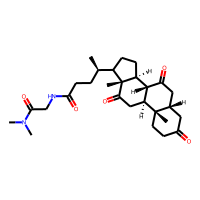
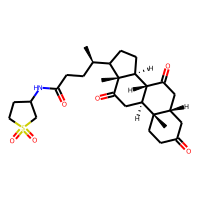
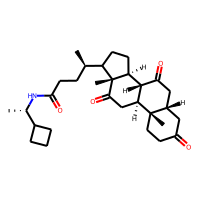
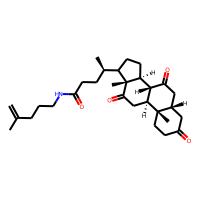
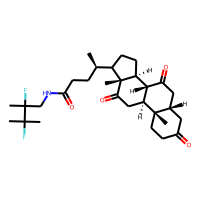
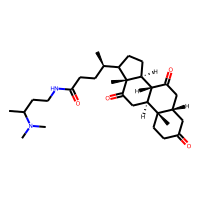
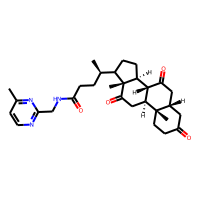
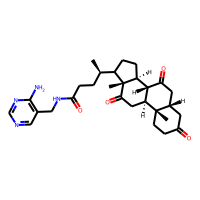
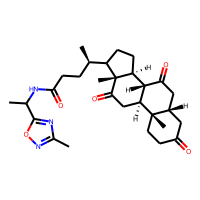
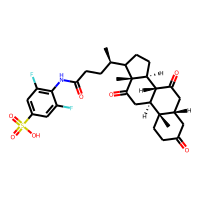
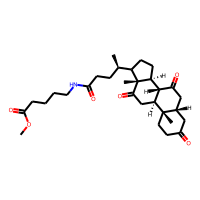
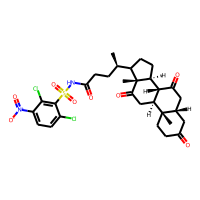
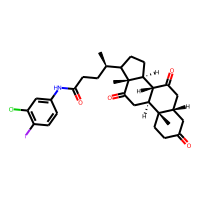
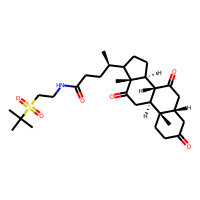
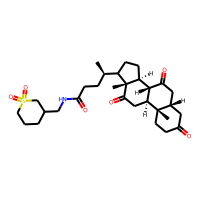
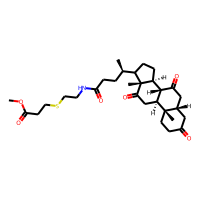
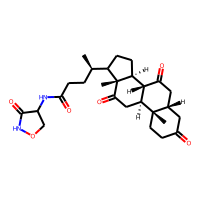
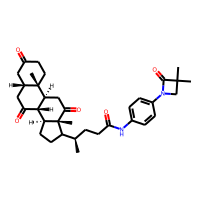
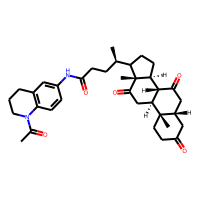
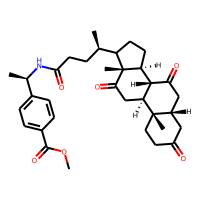
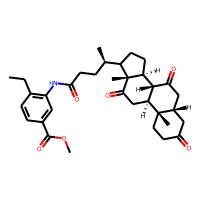
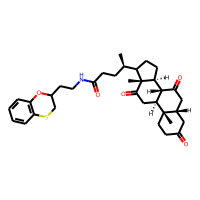
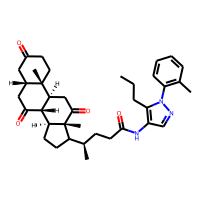
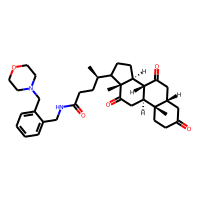
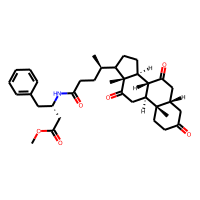
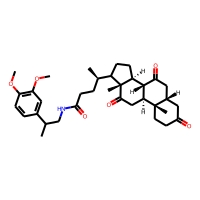
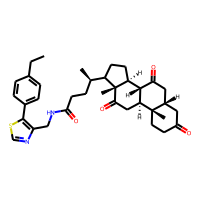
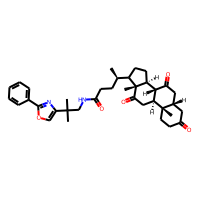
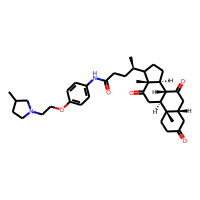
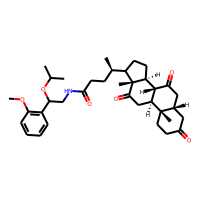
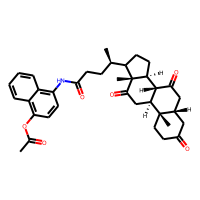
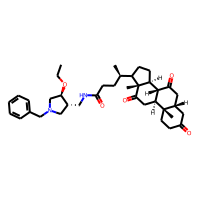
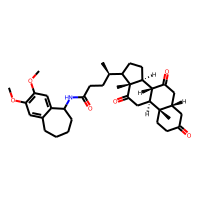
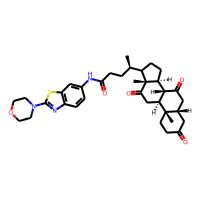
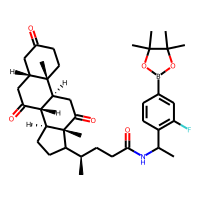
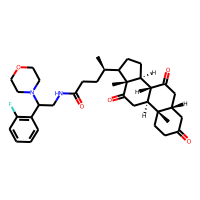
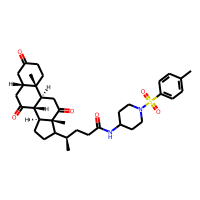
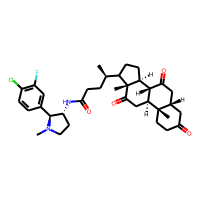
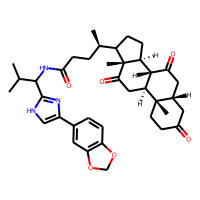
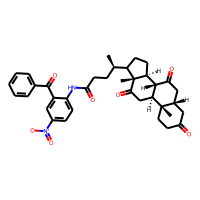
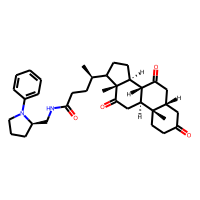
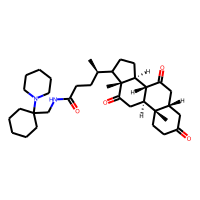
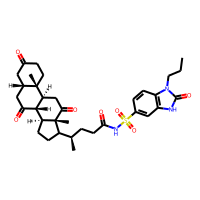
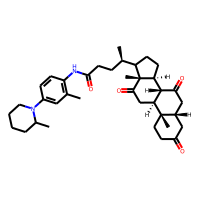
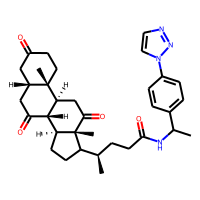
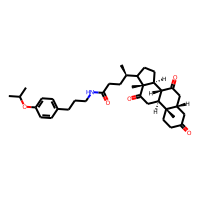
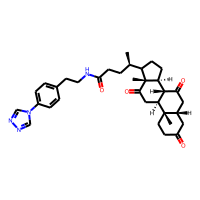
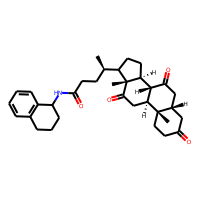
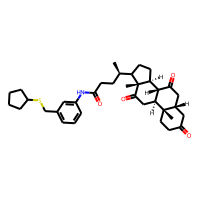
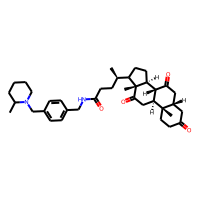
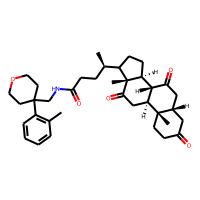
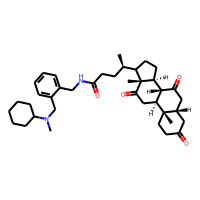
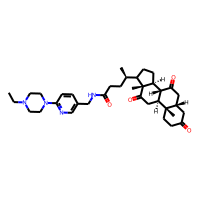
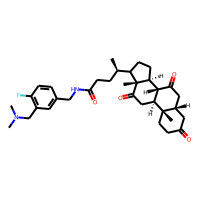
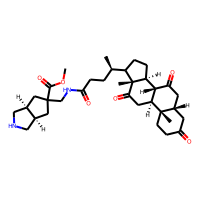
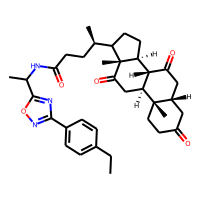
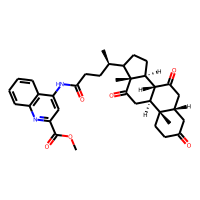
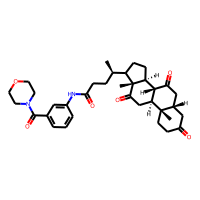
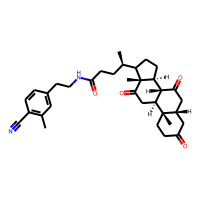
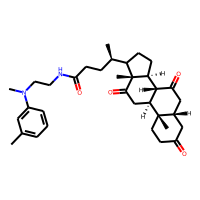
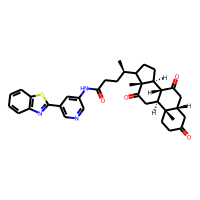
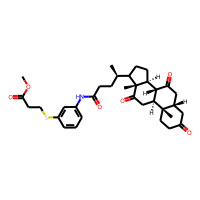
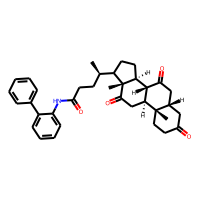
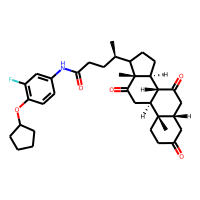
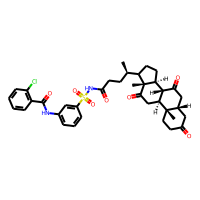
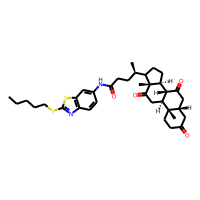
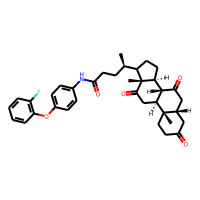
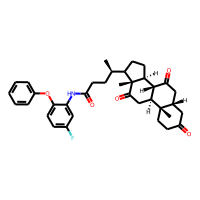
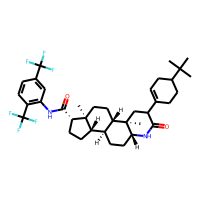
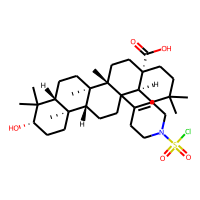
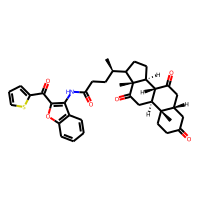
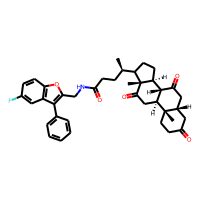
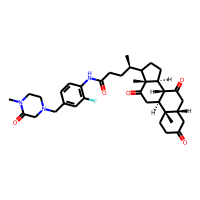
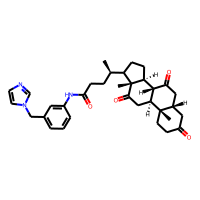
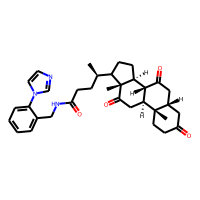
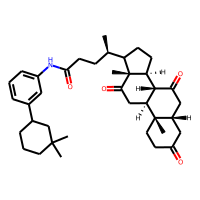
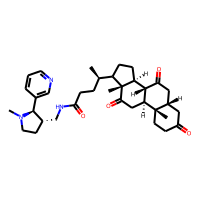
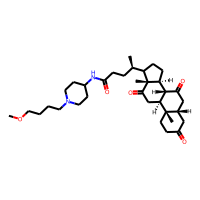
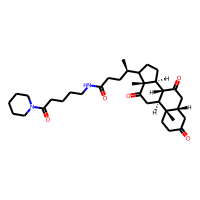
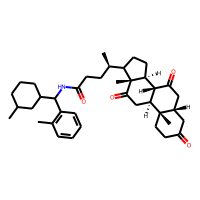
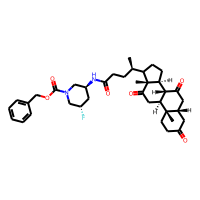
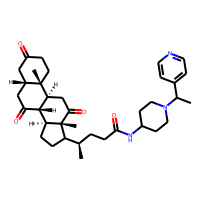
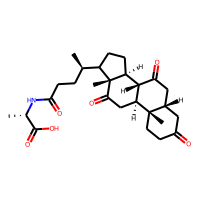
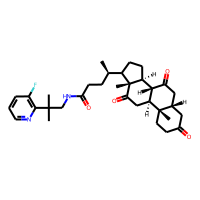
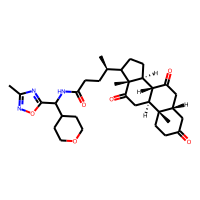
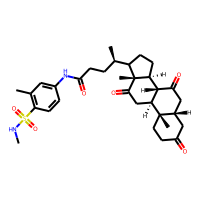
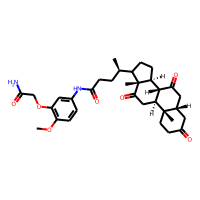
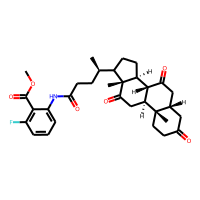
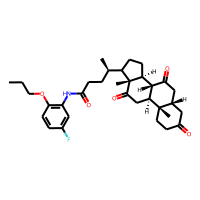
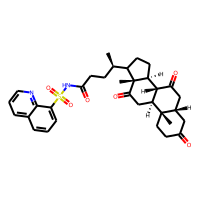
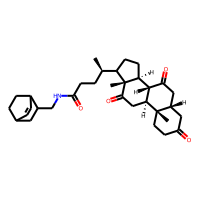
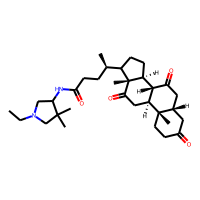
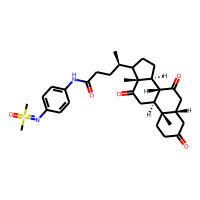
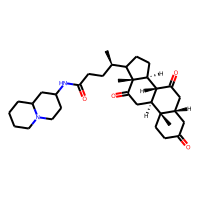
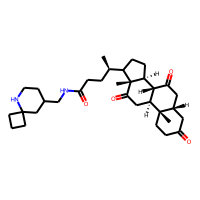
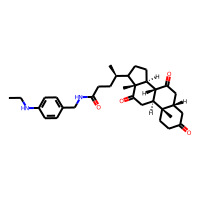
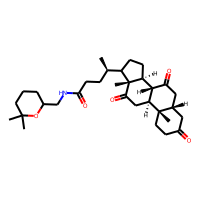
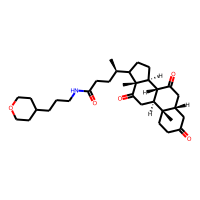
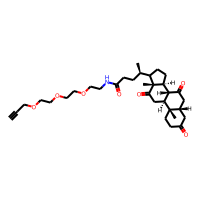
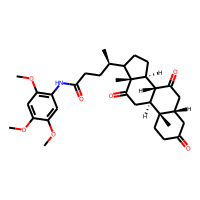
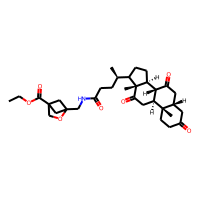
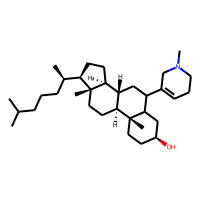
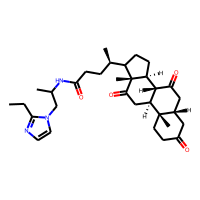
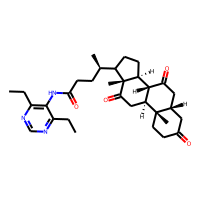
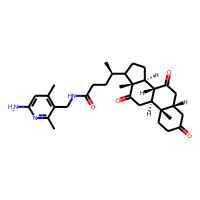
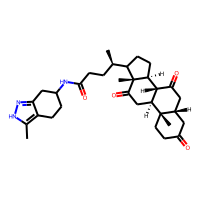
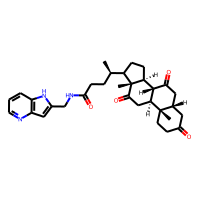
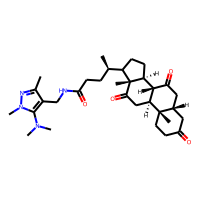
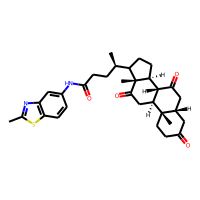
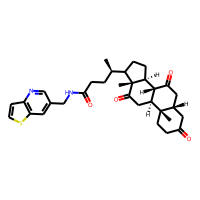
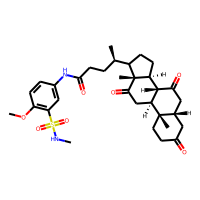
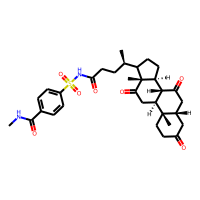
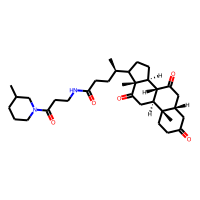
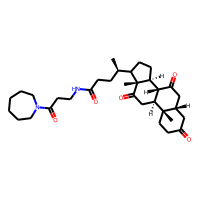
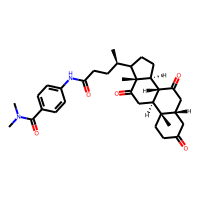
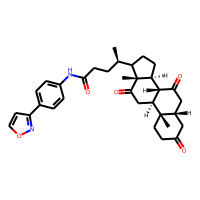
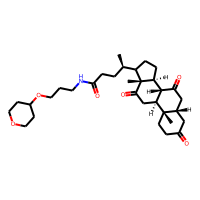
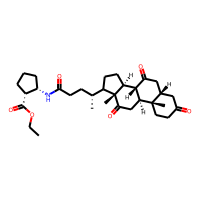
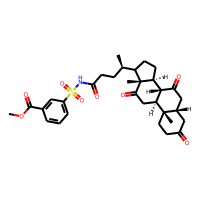
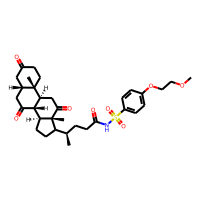
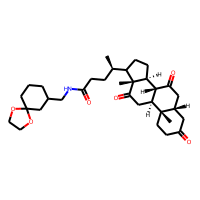
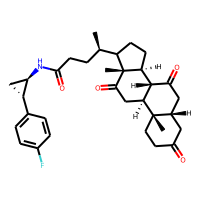
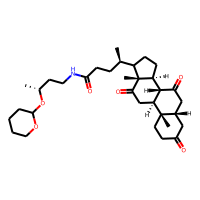
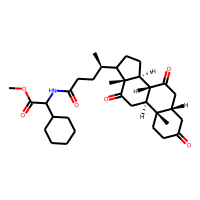
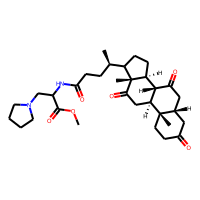
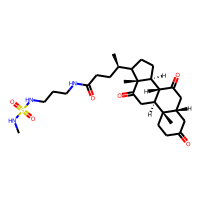
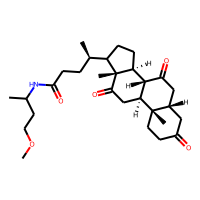
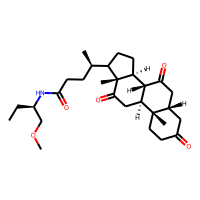
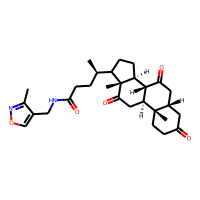
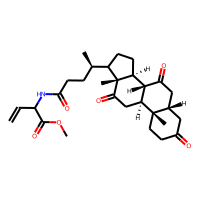
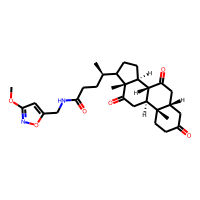
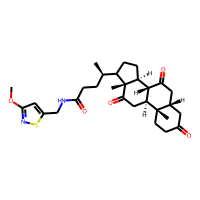
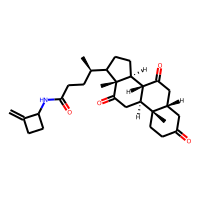
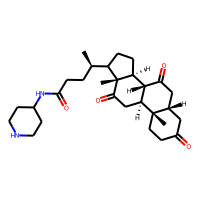
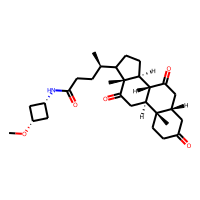
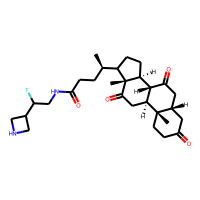
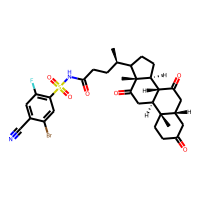
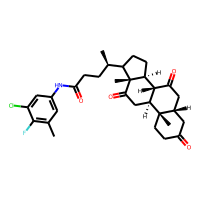
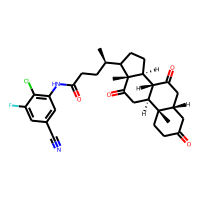
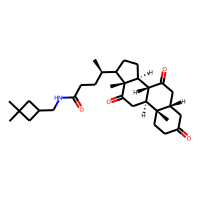
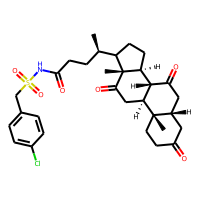
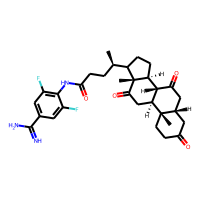
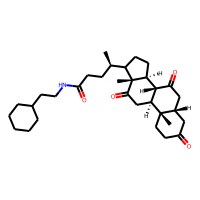
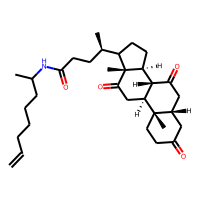
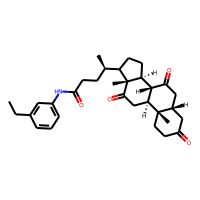
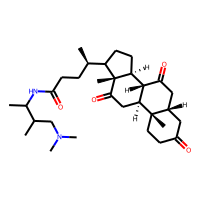
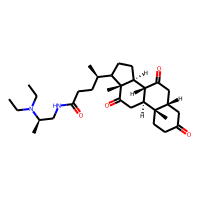
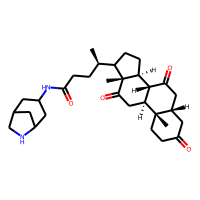
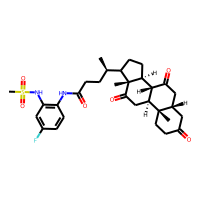
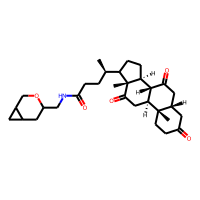
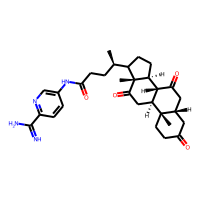
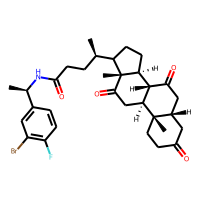
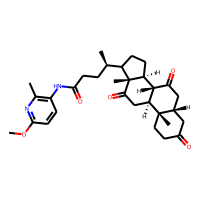
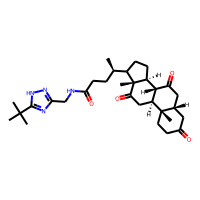
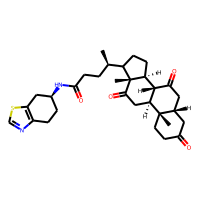
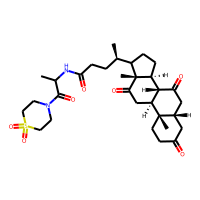
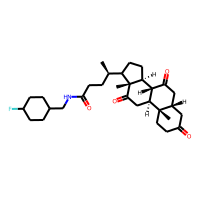
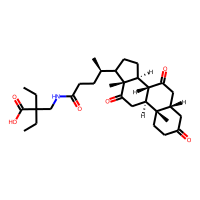
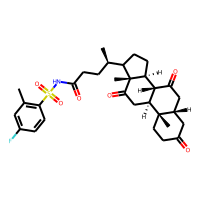
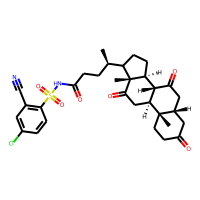
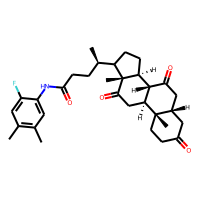
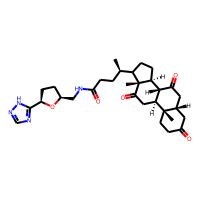
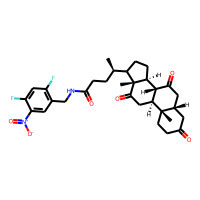

In [113]:
show_df(df)

## Perform Morgan Similarity Search

In [115]:
%%timeit -n 1 -r 1
%%bigquery df

CALL `cheminformatics.morgan_similarity_radius`("C[C@@H](CC(=C)C)C(=O)OCC1[C@@H]2COC[C@H]12", 4, 0.75)

Downloading: 100%|██████████| 9/9 [00:01<00:00,  4.80rows/s]

3.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [116]:
add_molecule_column(df)

,smiles,m
0,COC(=O)C[C@H](Br)C(=O)OCC1[C@@H]2COC[C@H]12,
1,O(CC1[C@@H]2COC[C@H]12)C(CC(C(C)C)C)=O,
2,CC(Cl)CC(=O)OCC1[C@@H]2COC[C@H]12,
3,O(CC1[C@@H]2COC[C@H]12)C(C[C@H](C)F)=O,
4,CNC(=O)NC(C)C(=O)OCC1[C@@H]2COC[C@H]12,
5,O(CC1[C@@H]2COC[C@H]12)C(CC(C(OC)=O)=C)=O,
6,CC(N1C(=O)CCC1=O)C(=O)OCC2[C@@H]3COC[C@H]23,
7,CC[C@H](C)[C@H](N)CC(=O)OCC1[C@@H]2COC[C@H]12,
8,CC(C)C[C@H](CC(=O)OCC1[C@@H]2COC[C@H]12)N,

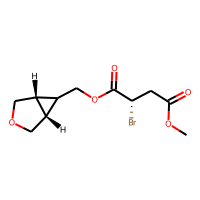
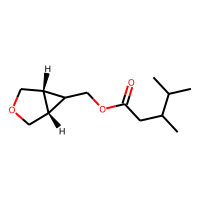
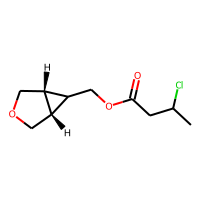
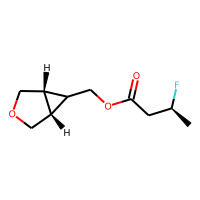
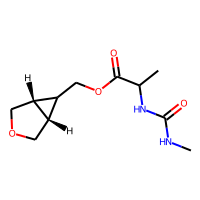
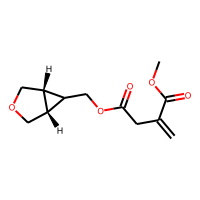
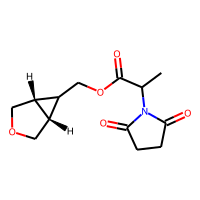
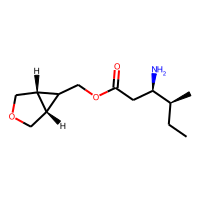
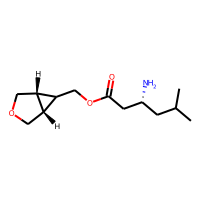

In [117]:
show_df(df)

# Summary

In the BigQuery project, you now have the cheminformatics dataset which has the two additional routines for substructure search and similarity search. 

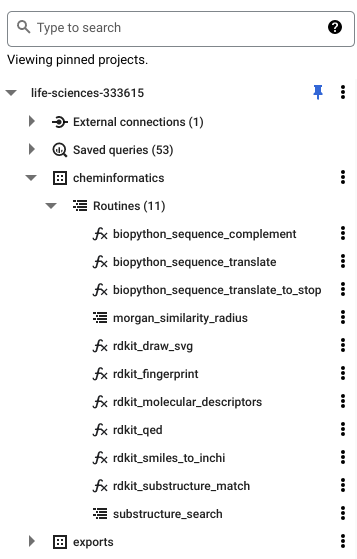